# Large NN probe

In [1]:
import torch
import shelve
import pandas as pd
import numpy as np
from torch.nn import BCELoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import pytorch_lightning as pl

In [2]:
%reload_ext tensorboard

In [5]:
%tensorboard --logdir tb_logs --port 6008

In [6]:
# Load data

concept_file = "/media/ap/storage/stockfish_data/concept_table3.csv"
df = pd.read_csv(concept_file)
db_name = 'stockfish_data_05'
concept = 'can_check'
layer = 1


In [7]:

## Load input
sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
X = np.array(sh["ckpt_data_official"][f"layer{layer}"])
sh.close()
X = X.reshape(X.shape[0], -1)

In [8]:


## fetch targets
Y = np.array(df[concept].values, dtype = np.float32)


undersample = RandomUnderSampler(
    sampling_strategy="majority"
)
# fit and apply the transform
X, Y = undersample.fit_resample(X, Y)

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f'X shape: {X.shape}, Y shape: {Y.shape}')
print(f'X dtype: {X.dtype}, Y dtype: {Y.dtype}')





X shape: torch.Size([86768, 2064]), Y shape: torch.Size([86768])
X dtype: torch.float32, Y dtype: torch.float32


In [9]:
# Split X into 80% train 10% test 10% val

Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=1)

Xte, Xdev, Yte, Ydev = train_test_split(Xte, Yte, test_size=0.5, random_state=1)

In [10]:
print('Ytr', Ytr.unique(return_counts=True))
print('Ydev', Ydev.unique(return_counts=True))
print('Yte', Yte.unique(return_counts=True))

Ytr (tensor([0., 1.]), tensor([34638, 34776]))
Ydev (tensor([0., 1.]), tensor([4420, 4257]))
Yte (tensor([0., 1.]), tensor([4326, 4351]))


In [11]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512

train_loader = DataLoader(TensorDataset( Xtr, Ytr ), batch_size= batch_size, num_workers = 32)
dev_loader = DataLoader(TensorDataset( Xdev, Ydev ), batch_size= batch_size, num_workers = 32)
test_loader = DataLoader(TensorDataset( Xte, Yte ), batch_size= batch_size, num_workers = 32)

In [12]:

def classification_cost(y_test, y_pred):
    residuals = 1 - torch.abs(y_pred - y_test)
    return torch.mean(residuals) * 2 - 1


In [13]:
# Create model

criterion = BCELoss()

class Feedforward(pl.LightningModule):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.bn1 = torch.nn.BatchNorm1d(self.hidden_size)
        self.nonlin1 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.bn2 = torch.nn.BatchNorm1d(self.hidden_size)
        self.nonlin2 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.bn3 = torch.nn.BatchNorm1d(self.hidden_size)
        self.nonlin3= torch.nn.ReLU()
        
        self.fc4 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()     
        
        
        self.single_linear = torch.nn.Linear(input_size, 1)
        
        
        self.learning_rate = 5e-6
        self.weight_decay = 1e-6
        
    def forward2(self, x):
        x = self.single_linear(x)
        output = self.sigmoid(x)
        return output
        
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.nonlin1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.nonlin2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.nonlin3(x)
        
        x = self.fc4(x)
        output = self.sigmoid(x)
        
        return output
    
    
    
    def test_dataloader(self):
        return test_loader
    
    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return dev_loader
    
        
        
    

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.forward(x)
        loss = criterion(z.view(-1), y)
        z_binary = (z > 0.5) * 1
        acc = classification_cost(y, z_binary.view(-1))
        return loss, acc
    

    def training_step(self, batch, batch_idx):
    
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"train_acc": acc, "train_loss": loss}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):

        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, batch, batch_idx):
       
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer



# Lightning training

In [14]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")


model = Feedforward(X.shape[1], 100)
trainer = pl.Trainer(gpus = 1, 
                     auto_lr_find=True, 
                     logger=logger, 
                     callbacks=[EarlyStopping(monitor="val_loss", mode="min", min_delta = 1e-8, patience=5)])
#trainer.tune(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/ap/PycharmProjects/stockfish_explain/stockfish_explain/experiments/probing_nnue/lr_find_temp_model_8522cb8a-e126-4cda-a759-5947492add31.ckpt


Set new learning rate as: 0.006918309709189364


/tmp/ipykernel_2213514/2063949559.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


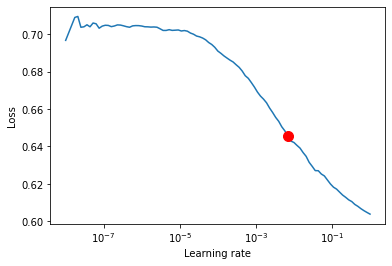

In [15]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
#print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.learning_rate = new_lr

print(f'Set new learning rate as: {new_lr}')

In [16]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type        | Params
-----------------------------------------------
0  | fc1           | Linear      | 206 K 
1  | bn1           | BatchNorm1d | 200   
2  | nonlin1       | ReLU        | 0     
3  | fc2           | Linear      | 10.1 K
4  | bn2           | BatchNorm1d | 200   
5  | nonlin2       | ReLU        | 0     
6  | fc3           | Linear      | 10.1 K
7  | bn3           | BatchNorm1d | 200   
8  | nonlin3       | ReLU        | 0     
9  | fc4           | Linear      | 101   
10 | sigmoid       | Sigmoid     | 0     
11 | single_linear | Linear      | 2.1 K 
-----------------------------------------------
229 K     Trainable params
0         Non-trainable params
229 K     Total params
0.918     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [24]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at tb_logs/my_model/version_28/checkpoints/epoch=61-step=8431.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at tb_logs/my_model/version_28/checkpoints/epoch=61-step=8431.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.48968538641929626, 'test_loss': 0.504250168800354}
--------------------------------------------------------------------------------


[{'test_acc': 0.48968538641929626, 'test_loss': 0.504250168800354}]

In [31]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at tb_logs/my_model/version_22/checkpoints/epoch=20-step=14594.ckpt
Loaded model weights from checkpoint at tb_logs/my_model/version_22/checkpoints/epoch=20-step=14594.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.4878414273262024, 'test_loss': 0.5244080424308777}
--------------------------------------------------------------------------------


[{'test_acc': 0.4878414273262024, 'test_loss': 0.5244080424308777}]

In [18]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at tb_logs/my_model/version_27/checkpoints/epoch=8-step=6254.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at tb_logs/my_model/version_27/checkpoints/epoch=8-step=6254.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.2898466885089874, 'test_loss': 0.6451565623283386}
--------------------------------------------------------------------------------


[{'test_acc': 0.2898466885089874, 'test_loss': 0.6451565623283386}]

In [14]:
# Compare with ridge regression
from sklearn.linear_model import RidgeClassifier, Ridge, LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor


XtrNP, YtrNP = Xtr.numpy(), Ytr.numpy()
XteNP, YteNP = Xte.numpy(), Yte.numpy()


ridge = RidgeClassifier()
lgbm = LGBMClassifier()


ridge.fit(XtrNP, YtrNP)
lgbm.fit(XtrNP, YtrNP)

ridge_pred = ridge.predict(XteNP)
lgbm_pred = lgbm.predict(XteNP)

print('ridge accuracy: ',classification_cost(Yte, torch.tensor(ridge_pred)))
print('lgbm accuracy: ',classification_cost(Yte, torch.tensor(lgbm_pred)))



/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.03886e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


ridge accuracy:  tensor(0.4772)
lgbm accuracy:  tensor(0.5185)


# Training

In [12]:


criterion = BCELoss()
model = Feedforward(X.shape[1], 100)


optimizer = Adam(model.parameters(), lr=0.0001)

# same optimization as last time
max_steps = 200000
batch_size = 256
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    optimizer.zero_grad()
    
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix] # batch X,Y
    
    x = model(Xb)
    
    loss = criterion(x.view(-1), Yb)
    
    loss.backward()
    
    optimizer.step()
    
    lossi.append(loss.log10().item())
    
    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    

      0/ 200000: 0.8218
    100/ 200000: 0.0478
    200/ 200000: 0.0162
    300/ 200000: 0.0109
    400/ 200000: 0.0071
    500/ 200000: 0.0060
    600/ 200000: 0.0052
    700/ 200000: 0.0042
    800/ 200000: 0.0028
    900/ 200000: 0.0031
   1000/ 200000: 0.0020
   1100/ 200000: 0.0018
   1200/ 200000: 0.0017
   1300/ 200000: 0.0013
   1400/ 200000: 0.0013
   1500/ 200000: 0.0016
   1600/ 200000: 0.0012
   1700/ 200000: 0.0008
   1800/ 200000: 0.0008
   1900/ 200000: 0.0008
   2000/ 200000: 0.0007
   2100/ 200000: 0.0005
   2200/ 200000: 0.0005
   2300/ 200000: 0.0004
   2400/ 200000: 0.0005
   2500/ 200000: 0.0005
   2600/ 200000: 0.0004
   2700/ 200000: 0.0004
   2800/ 200000: 0.0003
   2900/ 200000: 0.0003
   3000/ 200000: 0.0003
   3100/ 200000: 0.0004
   3200/ 200000: 0.0003
   3300/ 200000: 0.0004
   3400/ 200000: 0.0002
   3500/ 200000: 0.0003
   3600/ 200000: 0.0003
   3700/ 200000: 0.0003
   3800/ 200000: 0.0002
   3900/ 200000: 0.0003
   4000/ 200000: 0.0002
   4100/ 200000:

KeyboardInterrupt: 

# Analysis

In [52]:
from torch.nn import BCELoss
from torch.optim import Adam


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

hooks = {}
for name, module in model.named_modules():
    if name != '':
        #print(name)
        hooks[name] = module.register_forward_hook(get_activation(name))

ix = torch.randint(0, X.shape[0], (32,))
Xb, Yb = X[ix], Y[ix] # batch X,Y

x = model(Xb)

In [47]:
activation.keys()

dict_keys(['fc1', 'bn1', 'tanh1', 'fc2', 'bn2', 'tanh2', 'fc3', 'sigmoid'])

layer 2 (     tanh1): mean +0.00, std 0.55, saturated: 0.09%
layer 5 (     tanh2): mean +0.00, std 0.63, saturated: 3.62%
layer 8 (     tanh3): mean -0.01, std 0.64, saturated: 2.66%


Text(0.5, 1.0, 'activation distribution')

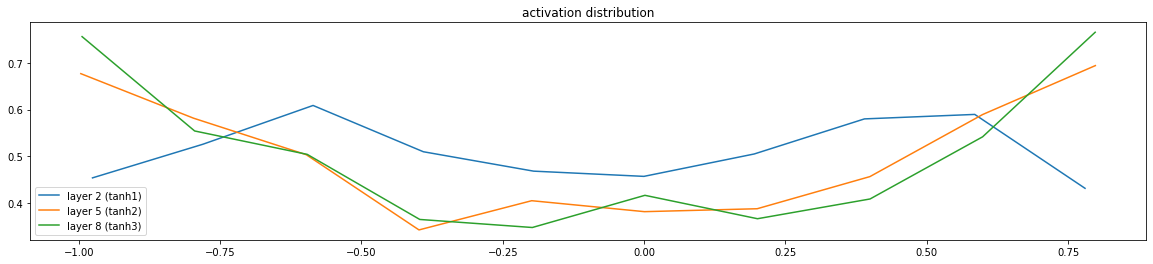

In [53]:
# visualize histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, (name, activations) in enumerate(activation.items()): # note: exclude the output layer
    if name in ['tanh1', 'tanh2', 'tanh3']:
        t = activations.flatten()
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, name, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = np.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f'layer {i} ({name})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (       fc1): mean +0.000000, std 0.000000e+00
layer 2 (       bn1): mean +0.000000, std 0.000000e+00
layer 4 (       fc2): mean +0.000000, std 0.000000e+00
layer 5 (       bn2): mean +0.000000, std 0.000000e+00
layer 7 (       fc3): mean +0.000000, std 0.000000e+00
layer 8 (       bn3): mean +0.000000, std 0.000000e+00
layer 10 (       fc4): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

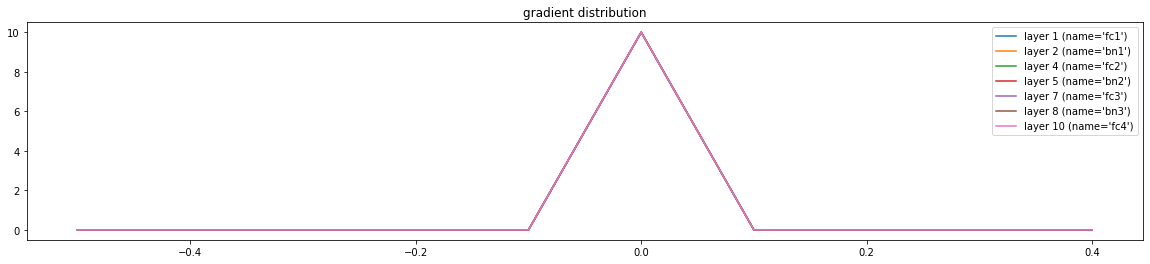

In [74]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, (name, param) in enumerate(model.named_modules()): # note: exclude the output layer
    if name not in ['', 'tanh1', 'tanh2', 'tanh3','sigmoid']:
        t = param.weight.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, name, t.mean(), t.std()))
        hy, hx = np.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f'layer {i} ({name=})')
plt.legend(legends);
plt.title('gradient distribution')

In [66]:
for name , param in model.named_modules():
    if name != '':
        print(name, param)
        print(param.weight.grad)

fc1 Linear(in_features=45056, out_features=100, bias=True)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
bn1 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tanh1 Tanh()


AttributeError: 'Tanh' object has no attribute 'weight'